### Qualitative visualization of what our planner does under the hood

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.50, 0.50), std=(0.35, 0.35), cvar(0.30)=(0.07, 0.07) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.53, 0.53) (computed from 10000.0 saved samples)


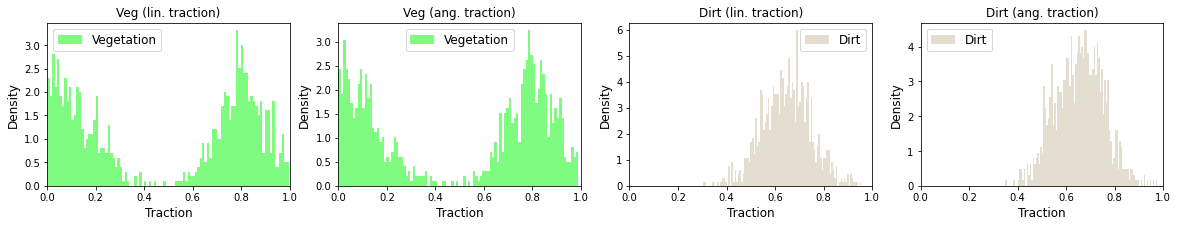

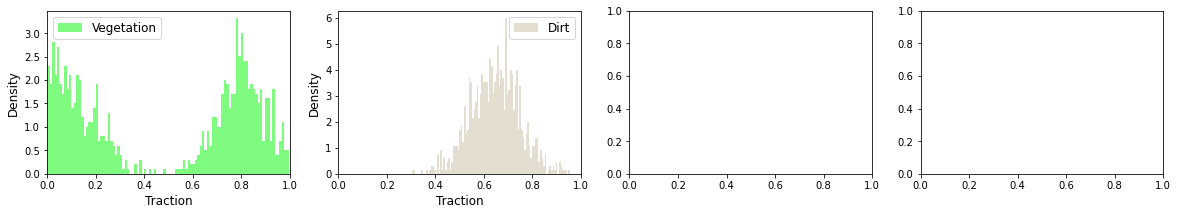

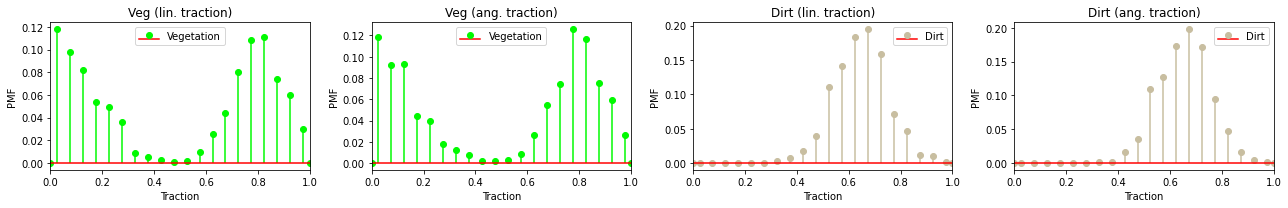

In [2]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3

pmf_bounds = [0, 1.0]
bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]
dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(20, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, color=bush.rgb)
vis_density(axes[1], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, color=dirt.rgb)


fig, axes = plt.subplots(1, 4, figsize=(18, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

TDM has initialized GPU memory after 0.35617923736572266 s
TDM has initialized GPU memory after 0.0003077983856201172 s
MPPI planner has initialized GPU memory after 0.01697397232055664 s


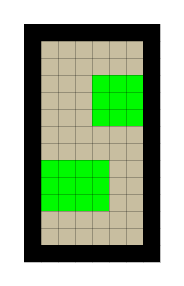

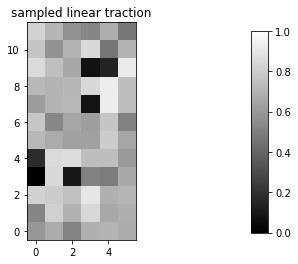

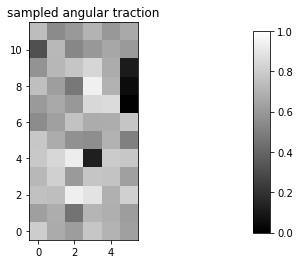

In [3]:
# ------------- Create and visualize the example map ------------
res = 1.0
semantic_grid = np.array([
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
  [1,1,1,1,0,0,],
  [1,1,1,1,0,0,],
  [1,1,1,1,0,0,],
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
  [0,0,0,1,1,1,],
  [0,0,0,1,1,1,],
  [0,0,0,1,1,1,],
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
])
# semantic_grid = np.array([
#   [0,0,0,0,0,0,],
#   [0,0,0,0,0,0,],
#   [1,1,1,1,0,0,],
  # [1,1,1,1,0,0,],
#   [1,1,1,1,0,0,],
#   [0,0,0,0,0,0,],
#   [0,0,0,0,0,0,],
#   [0,0,1,1,1,1,],
#   [0,0,1,1,1,1,],
#   [0,0,1,1,1,1,],
#   [0,0,0,0,0,0,],
#   [0,0,0,0,0,0,],
# ])

grid_shape = semantic_grid.shape

xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0

use_tdm = False # True
use_det_dynamics = True # True
use_nom_dynamics_with_speed_map = False
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024,
  num_control_rollouts = 1024,
  max_speed_padding = 5.0,
  # tdm_sample_thread_dim = (16,16),
  num_vis_state_rollouts = 25,
  max_map_dim =(15, 15),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# ------------- Problem configuration ------------
# x0=np.array([1, 1, np.pi/4])
x0=np.array([1, 1, 0])
xgoal= np.array([grid_shape[1]-1, grid_shape[0]-1])
# xgoal= np.array([2, grid_shape[0]-1])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,

    # For risk-aware min time planning
    goal_tolerance=1.0,
    v_post_rollout=0.01, # 0.01,
    cvar_alpha=0.4, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0, # 1.0,
    num_opt= 1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params['cvar_alpha'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params['cvar_alpha'])
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))

mppi_planner = MPPI_Numba(cfg)

# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()



/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


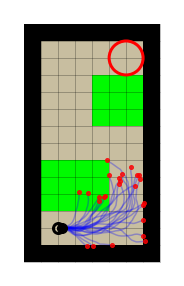

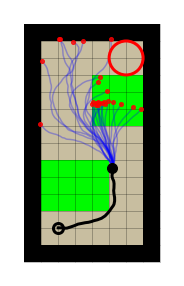

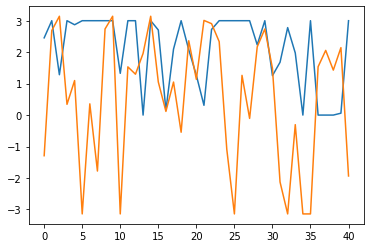

In [4]:
# Construct the MPPI planner + initialize the GPU variables
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# Loop
max_steps = 150
max_steps = 41#150
# max_steps = 1
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 40
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ko', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ko', markersize=10, label="Curr. State", zorder=5)
    # c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, label="Goal", zorder=6)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, zorder=6)
    c1_dummpy = ax.plot([xgoal[0]-1e6], [xgoal[1]-1e6], 'ro', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Goal", zorder=6)
    ax.add_patch(c1)

    # # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'k', linewidth=3, label="Past State")
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', alpha=0.8, markersize=8, zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', alpha=0.3, zorder=3)
    # For the legends
    # ax.plot([1e6], [1e6], 'b-', label="Rollouts")
    # ax.legend(ncol=5)
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break


fig, ax = plt.subplots()
ax.plot(uhist[:,0])
ax.plot(uhist[:,1])

Visualize the rollouts of the proposed planner over environments

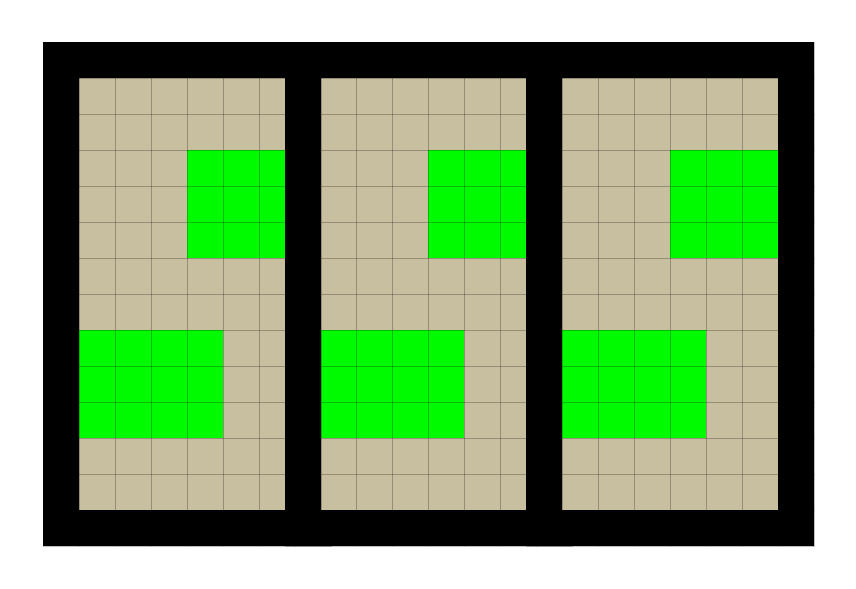

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 9))
fig, ax = lin_tdm_vis.draw(ax=axes[0])
fig, ax = lin_tdm_vis.draw(ax=axes[1])
fig, ax = lin_tdm_vis.draw(ax=axes[2])
plt.subplots_adjust(wspace=-0.73, hspace=0)
plt.tight_layout()

TDM has initialized GPU memory after 0.04168963432312012 s
TDM has initialized GPU memory after 0.04048347473144531 s
MPPI planner has initialized GPU memory after 0.01628255844116211 s


/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


goal reached at t=95
TDM has initialized GPU memory after 0.04009842872619629 s
TDM has initialized GPU memory after 0.03989052772521973 s
MPPI planner has initialized GPU memory after 0.01621532440185547 s
goal reached at t=92
TDM has initialized GPU memory after 0.0004436969757080078 s
TDM has initialized GPU memory after 0.00022673606872558594 s
MPPI planner has initialized GPU memory after 0.016064167022705078 s


/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TDM has initialized GPU memory after 0.0002713203430175781 s
TDM has initialized GPU memory after 0.00022125244140625 s
MPPI planner has initialized GPU memory after 0.016191720962524414 s
goal reached at t=86


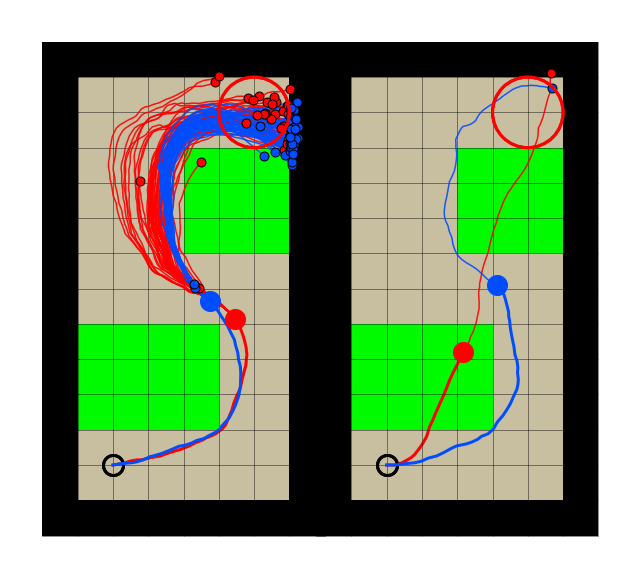

In [6]:
# Sample a traction grid
traction_grid = lin_tdm.sample_grids_true_dist()



def visualize_trial(ax, method, alpha, plot_at_t, default_cfg, default_mppi_params, num_state_rollout=100, max_steps=150, seed=1, draw_grid=True,
rollout_alpha=0.2, terminal_alpha=1.0, rollout_color='b', state_color='r', goal_color="red", past_state_color='k'):
  mppi_params = copy.deepcopy(default_mppi_params)
  mppi_params['cvar_alpha'] = alpha
  cfg = copy.deepcopy(default_cfg)
  cfg.seed = seed

  if method == 'noisy_dyn':
    cfg.use_tdm = True
    cfg.use_det_dynamics = False
    cfg.use_nom_dynamics_with_speed_map = False
    cfg.num_vis_state_rollouts = num_state_rollout

  elif method == 'risk_dyn':
    cfg.use_tdm = False
    cfg.use_det_dynamics = True
    cfg.use_nom_dynamics_with_speed_map = False
    cfg.num_vis_state_rollouts = 1

  elif method == 'nom_dyn_risk_cost':
    cfg.use_tdm = False
    cfg.use_det_dynamics = False
    cfg.use_nom_dynamics_with_speed_map = True
    cfg.num_vis_state_rollouts = 1
  else:
    assert False

  lin_tdm = TDM_Numba(cfg)
  ang_tdm = TDM_Numba(cfg)
  lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                      xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                      mppi_params['cvar_alpha'])
  ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                      xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                      mppi_params['cvar_alpha'])

  mppi_planner = MPPI_Numba(cfg)
  mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

  # Loop
  xhist = np.zeros((max_steps+1, 3))*np.nan
  uhist = np.zeros((max_steps, 2))*np.nan
  xhist[0] = x0

  for t in range(max_steps):
    # Solve
    useq = mppi_planner.solve()
    u_curr = useq[0]
    uhist[t] = u_curr

    # Simulate state forward using the sampled map
    lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
    xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
    xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
    xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


    if t==plot_at_t:
      # Visualize the basic set up
      lin_tdm_vis = TDM_Visualizer(lin_tdm)
      if draw_grid:
        fig, ax = lin_tdm_vis.draw(ax=ax, figsize=None)


      ax.plot([x0[0]], [x0[1]], 'ko', markersize=20, markeredgewidth=3, markerfacecolor='none', label="Start")
      ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'o', color=state_color, markersize=20, label="Curr. State", zorder=5)
      # c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, label="Goal", zorder=6)
      c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color=goal_color, linewidth=3, fill=False, zorder=6)
      c1_dummpy = ax.plot([xgoal[0]-1e6], [xgoal[1]-1e6], 'o', color=state_color, markersize=10, markeredgewidth=3, markerfacecolor='none', label="Goal", zorder=6)
      ax.add_patch(c1)

      # Get rollout states from subset of maps for visualization?
      rollout_states_vis = mppi_planner.get_state_rollout()

      # # Process to keep untill the state hits the goal region
      # terminal_t = []
      # for ri, rollout in enumerate(rollout_states_vis):
      #   reached = False
      #   for rt in range(len(rollout)):
      #     if reached:
      #       break
      #     reached = np.linalg.norm(np.array(mppi_params['xgoal'])-rollout[rt, :2])<=mppi_params['goal_tolerance']
      #     if reached:
      #       terminal_t.append(rt)
      #     elif rt == len(rollout)-1:
      #       terminal_t.append(rt)


      ax.plot(xhist[:,0], xhist[:,1], color=past_state_color, linewidth=3, label="Past State")
      ax.scatter(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, s=80,
            color=state_color, alpha=terminal_alpha, zorder=4,edgecolor='k',
            label="Terminal State")


      ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, color=rollout_color, alpha=rollout_alpha, zorder=3)
      # ax.plot(rollout_states_vis[:,terminal_t,0].T, rollout_states_vis[:,terminal_t,1].T, '.',
      #        color=state_color, alpha=terminal_alpha, markersize=12, zorder=4,label="Terminal State")
      # for ri, tt in enumerate(terminal_t):
      #   ax.plot(rollout_states_vis[ri,:tt,0].T, rollout_states_vis[ri,:tt,1].T, color=rollout_color, alpha=rollout_alpha, zorder=3)
      # For the legends
      ax.plot([1e6], [1e6], '-', color=rollout_color, label="Rollouts")
    
    # Update MPPI state (x0, useq)
    mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

    
    # Goal check
    if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
      print("goal reached at t={}".format(t))
      break

fig, axes = plt.subplots(ncols=2, figsize=(9, 9))
seed = 1
plot_at_t= 50 # 39
num_state_rollout=51
max_steps=101
alpha1 = 1.0
alpha2 = 0.5
alpha3 = 0.2
clr1 = (1,0,0)
clr2 = (0,0.3,1)
clr3 = (0,1,1)
rollout_alpha=0.9
past_state_color1 = clr1
past_state_color2 = clr2
past_state_color3 = clr3
visualize_trial(axes[0], method="noisy_dyn", alpha=alpha1, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
              num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
              state_color=clr1, rollout_color=clr1, 
              rollout_alpha=rollout_alpha, terminal_alpha=1.0, past_state_color=past_state_color1)
visualize_trial(axes[0], method="noisy_dyn", alpha=alpha2, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
              state_color=clr2, rollout_color=clr2, num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
              rollout_alpha=rollout_alpha, past_state_color=past_state_color2)
# visualize_trial(axes[0], method="noisy_dyn", alpha=alpha3, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
#               state_color=clr3, rollout_color=clr3, num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
#               rollout_alpha=rollout_alpha, past_state_color=past_state_color3)

visualize_trial(axes[1], method="risk_dyn", alpha=alpha1, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
              num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
              rollout_alpha=rollout_alpha, 
              state_color=clr1, rollout_color=clr1, past_state_color=past_state_color1)
visualize_trial(axes[1], method="risk_dyn", alpha=alpha2, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
              num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
              rollout_alpha=rollout_alpha, 
              state_color=clr2, rollout_color=clr2, past_state_color=past_state_color2)
# visualize_trial(axes[1], method="risk_dyn", alpha=alpha3, plot_at_t=plot_at_t, default_cfg=cfg, default_mppi_params=mppi_params, 
#               num_state_rollout=num_state_rollout, max_steps=max_steps, seed=seed, 
#               rollout_alpha=rollout_alpha, 
#               state_color=clr3, rollout_color=clr3, past_state_color=past_state_color3)
plt.subplots_adjust(wspace=-0.73, hspace=0)
plt.tight_layout()

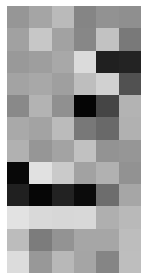

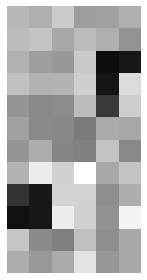

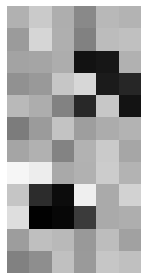

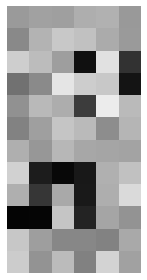

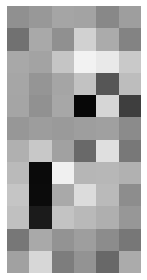

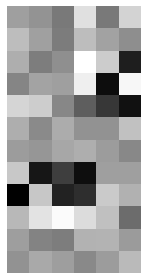

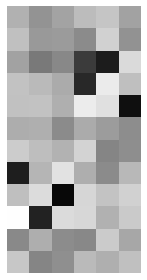

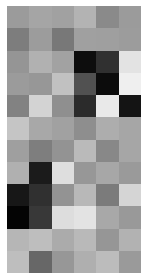

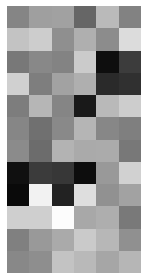

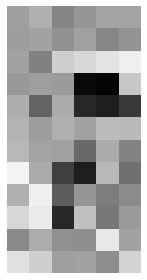

In [7]:
# Can we visualize the result of a s

for index in range(10):
  traction_grid = lin_tdm.sample_grids_true_dist()
  fig, ax = plt.subplots()
  ang = traction_grid.ang_traction
  img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
  fig.subplots_adjust(right=0.85)
  # cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
  # fig.colorbar(img, cax=cbar_ax)
  ax.axis("off")
  plt.tight_layout()
  # plt.savefig('plots/sampled_tractions/{}.png'.format(index), dpi=100, bbox_inches='tight')
  plt.show()


0.49322360216496514 0.17016119324606285 0.6470367991626063 0.5660136866412655


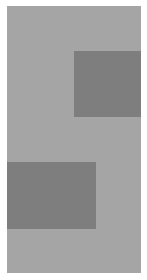

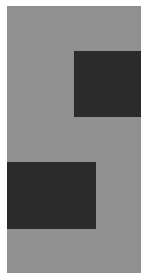

In [19]:
# Can we also get mean grid?
bush_mean = bush_lin_gm.mean()
bush_cvar05, bush_thres = bush_lin_gm.cvar(0.5)
dirt_mean = dirt_lin_gm.mean()
dirt_cvar05, dirt_thres = dirt_lin_gm.cvar(0.5)


print(bush_mean, bush_cvar05, dirt_mean, dirt_cvar05)
mean_grid = np.ones_like(semantic_grid, dtype=float)
mean_grid[semantic_grid==0] = dirt_mean
mean_grid[semantic_grid==1] = bush_mean
cvar_grid = np.zeros_like(semantic_grid, dtype=float)
cvar_grid[semantic_grid==0] = dirt_cvar05
cvar_grid[semantic_grid==1] = bush_cvar05

fig, ax = plt.subplots()
img = ax.imshow(mean_grid, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.axis("off")
plt.tight_layout()
plt.savefig('plots/sampled_tractions/mean_grid.png'.format(index), dpi=100, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
img = ax.imshow(cvar_grid, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.axis("off")
plt.tight_layout()
plt.savefig('plots/sampled_tractions/cvar05_grid.png'.format(index), dpi=100, bbox_inches='tight')
plt.show()

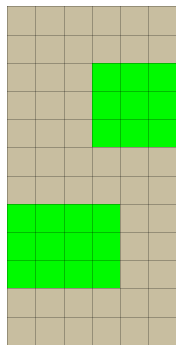

In [27]:
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
rows, cols = lin_tdm_vis.semantic_grid.shape
offset = lin_tdm_vis.pad_width*lin_tdm_vis.cell_dimensions[0]
ax.set_xlim([lin_tdm_vis.xlimits[0]+offset, lin_tdm_vis.xlimits[1]-offset])
ax.set_ylim([lin_tdm_vis.ylimits[0]+offset, lin_tdm_vis.ylimits[1]-offset])
plt.tight_layout()
plt.savefig('plots/sampled_tractions/semantic_grid_no_padding.png'.format(index), dpi=100, bbox_inches='tight')

1